In [2]:
import torch
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import random

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
#from helper.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
import helper.image_utils
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [4]:
from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread
import platform

def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.

    Inputs:
    - num: Number of images to load (max of 25)

    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    #imagenet_fn = 'cs231n/datasets/imagenet_val_25.npz'
    imagenet_fn = 'imagenet_val_25.npz'
    if not os.path.isfile(imagenet_fn):
      print('file %s not found' % imagenet_fn)
      print('Run the following:')
      print('cd cs231n/datasets')
      print('bash get_imagenet_val.sh')
      assert False, 'Need to download imagenet_val_25.npz'
    f = np.load(imagenet_fn)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

In [5]:
#from helper.data_utils import load_imagenet_val
#import helper.data_utils as h
X, y, class_names = load_imagenet_val(num=5)

In [6]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Scale(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

In [7]:
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        #X = torch.cat([right, left], dim=3)
        X = torch.cat([right, left], 3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        #X = torch.cat([bottom, top], dim=2)
        X = torch.cat([bottom, top], 2)
    return X

In [21]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    #l2_reg = kwargs.pop('l2_reg', 1e-3)
    l2_reg = kwargs.pop('l2_reg', 1e-5)
    #learning_rate = kwargs.pop('learning_rate', 25)
    learning_rate = kwargs.pop('learning_rate', 10)
    num_iterations = kwargs.pop('num_iterations', 1000)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and also wrap it in
    # a PyTorch Variable.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype)
    #img = torch.zeros(1,3,224,224).mul_(1.0).type(dtype)
    img_var = Variable(img, requires_grad=True)

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.copy_(jitter(img, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        img_var = Variable(img, requires_grad=True)
        
        outputs = model(img_var)
        #print(outputs)
        data_loss = outputs[0][target_y]
        
        reg_loss = l2_reg*torch.norm(img, p=2)
        loss = data_loss - reg_loss
        
        loss.backward()
    
        g = img_var.grad.data 
        #print(g)
        g_norm = torch.norm(g, p=2)
        dx = learning_rate * g /g_norm
        img += dx - l2_reg*img
        
        # zero out gradients before next step
        img_var.grad.data.zero_()
        
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.copy_(jitter(img, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
            SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)
            
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.clone().cpu()))
            #class_name = class_names[target_y]
            #plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(6, 6)
            plt.axis('off')
            plt.show()

    return deprocess(img.cpu())

In [10]:
# Download and load the pretrained SqueezeNet model.
#model = torchvision.models.squeezenet1_1(pretrained=True)
#model = torch.load('weightedloss_lrloop.pt')
model = torch.load('weightedloss_lrloop_randomflip_alexnet.pt')
model_original = torch.load('weightedloss_lrloop_randomflip_alexnet.pt')
model_less1 = torch.load('weightedloss_lrloop_randomflip_alexnet.pt')
model_less2 = torch.load('weightedloss_lrloop_randomflip_alexnet.pt')
model_less3 = torch.load('weightedloss_lrloop_randomflip_alexnet.pt')

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

In [11]:
#print(*list(model.classifier.children())[:-2])
model_less1.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-2])
model_less2.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-5])
model_less3.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-7])

In [20]:
print(model_less1)

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
  )
)


In [1]:
#print(model_original.state_dict())
#print(model.state_dict('classifer.4.weight'))

In [114]:
print(model_original.state_dict()['classifier.6.weight'][1][0])
max_index = 0
max_value = 0
weight_array = [0]*len(model_original.state_dict()['classifier.6.weight'][1])

file = open('weights.txt','w') 

for i in range(len(model_original.state_dict()['classifier.6.weight'][1])):
    file.write(str(i)+",")
    weight_data = model_original.state_dict()['classifier.6.weight'][1][i]
    print(str(i)+","+str(weight_data))
    file.write(str(weight_data)+"\n")
    weight_array[i] = weight_data
    if weight_data > max_value:
        max_index = i
        max_value = weight_data

#file.close() 

print(max_index)
print(max_value)

-0.005640448071062565
0,-0.005640448071062565
1,-0.010193047113716602
2,0.002051272429525852
3,0.000669099681545049
4,-0.01059674471616745
5,0.004810113459825516
6,-0.007085025776177645
7,0.014408783055841923
8,0.013131042011082172
9,0.013185021467506886
10,0.006042303051799536
11,0.02426261454820633
12,0.000451411004178226
13,-0.006985303945839405
14,-0.014218833297491074
15,0.008693788200616837
16,0.013029472902417183
17,0.0021301342640072107
18,-0.0031339453998953104
19,-0.01404601614922285
20,0.009408099576830864
21,-0.013696728274226189
22,0.00800975039601326
23,-0.016798321157693863
24,0.003567645326256752
25,-0.0010668651666492224
26,0.011601490899920464
27,-0.009762052446603775
28,0.008451933041214943
29,0.0015697804046794772
30,0.009515658020973206
31,0.0016030024271458387
32,0.001350927515886724
33,0.0030235112644732
34,-0.012829812243580818
35,-0.015702662989497185
36,-0.0087930578738451
37,-0.016033455729484558
38,-0.006477707531303167
39,0.0024733939208090305
40,-0.0012874

In [103]:
#print(weight_array)
print(np.argsort(weight_array)[-5::])

[3879  371  431 2916 1963]


In [119]:
print(model_original.state_dict()['classifier.4.weight'][3338][0])
max_index = 0
max_value = 0
weight_array = [0]*len(model_original.state_dict()['classifier.4.weight'][3338])

file = open('weights.txt','w') 

for i in range(len(model_original.state_dict()['classifier.4.weight'][3338][:])):
    file.write(str(i)+",")
    weight_data = model_original.state_dict()['classifier.4.weight'][3338][i]
    print(str(i)+","+str(weight_data))
    file.write(str(weight_data)+"\n")
    weight_array[i] = weight_data
    if weight_data > max_value:
        max_index = i
        max_value = weight_data

#file.close() 

print(max_index)
print(max_value)

0.012135487049818039
0,0.012135487049818039
1,-0.00800168327987194
2,-0.003159527899697423
3,0.012174329720437527
4,0.0031203618273139
5,-0.00039207725785672665
6,-0.00881992932409048
7,-0.007245725020766258
8,-0.0020440355874598026
9,0.00011859529331559315
10,-0.01677616685628891
11,0.005398652516305447
12,-0.015016579069197178
13,0.012648220174014568
14,-0.011400511488318443
15,-0.007508728187531233
16,-0.01302038412541151
17,0.006648382171988487
18,0.00747642619535327
19,0.011222966946661472
20,0.00022921650088392198
21,-0.013325504027307034
22,0.019620288163423538
23,-0.014083849266171455
24,0.0006634350284002721
25,0.0016500671626999974
26,0.0012730928137898445
27,0.002823163755238056
28,0.007249427028000355
29,-0.0014772224240005016
30,-0.0035533462651073933
31,-0.0006784379365853965
32,-0.007185627706348896
33,-0.014446771703660488
34,0.009787967428565025
35,-0.01026867050677538
36,-0.00712290033698082
37,-0.0076102144084870815
38,0.0009575397125445306
39,-0.009051725268363953
4

In [120]:
#print(weight_array)
print(np.argsort(weight_array)[-5::])

[1414 3735 3925 2272  713]


In [161]:
#print(model_original.state_dict()['classifier.6.weight'][:][500])
max_index = 0
max_value = 0


for i in range(5):
    file.write(str(i)+",")
    weight_data = model_original.state_dict()['classifier.6.weight'][i][7]
    bias_data = model_original.state_dict()['classifier.6.bias'][i]
    print(str(i)+","+str(weight_data+bias_data))
    if (weight_data+bias_data) > max_value:
        max_index = i
        max_value = weight_data + bias_data

#file.close() 

print(max_index)
print(max_value)

0,-0.01397975703002885
1,0.0031366413459181786
2,-0.011282742605544627
3,-0.03238751366734505
4,0.0227012038230896
4
0.0227012038230896


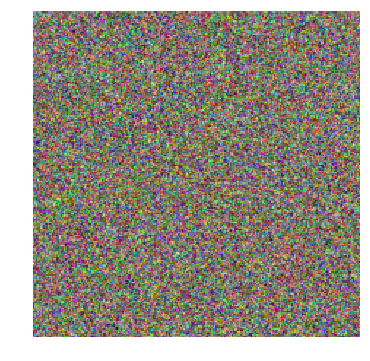

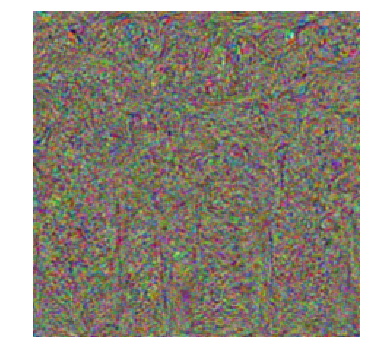

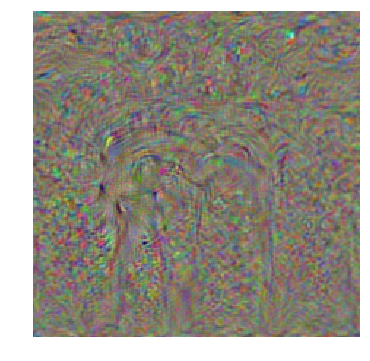

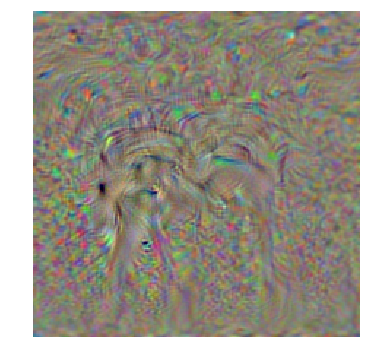

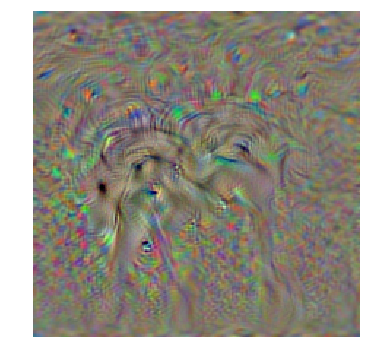

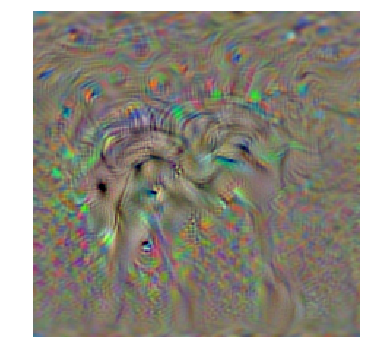

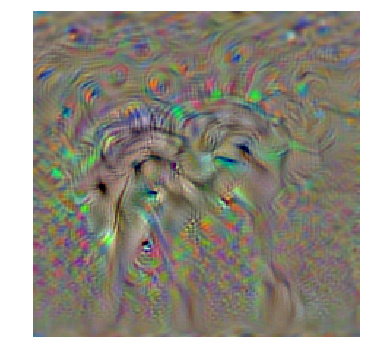

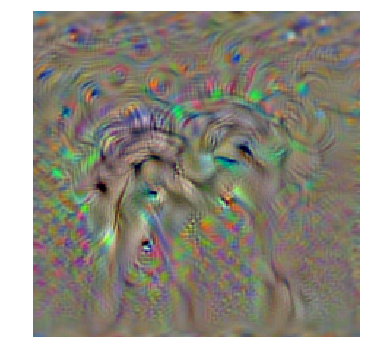

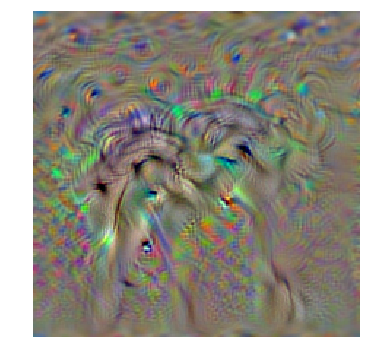

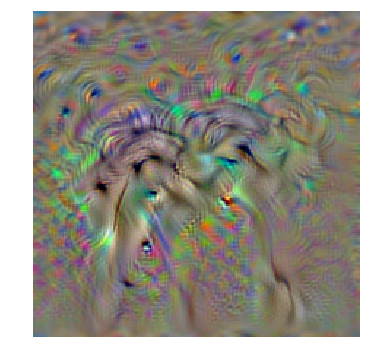

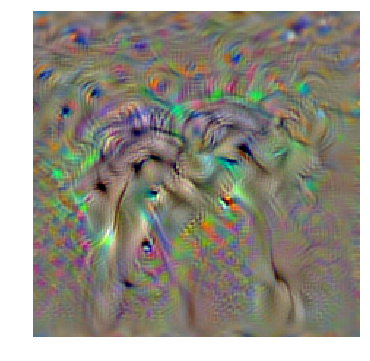

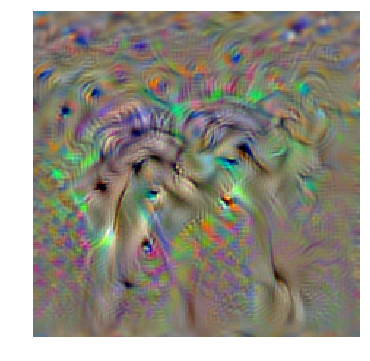

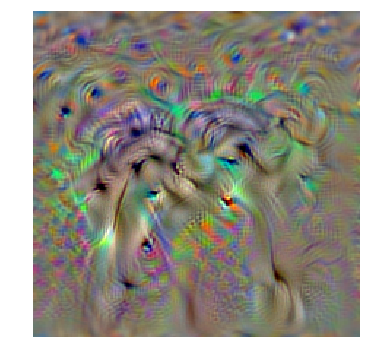

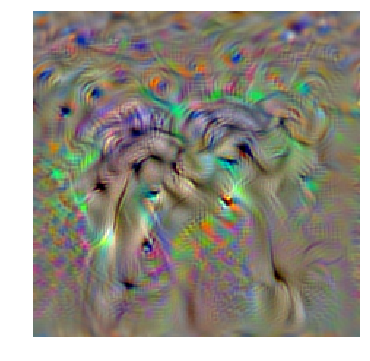

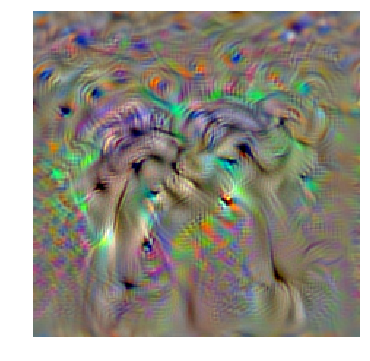

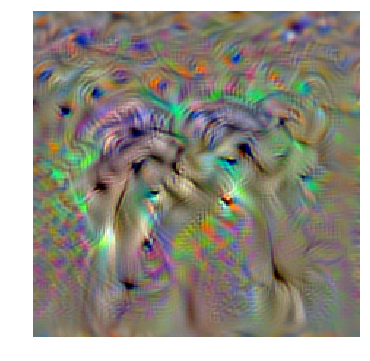

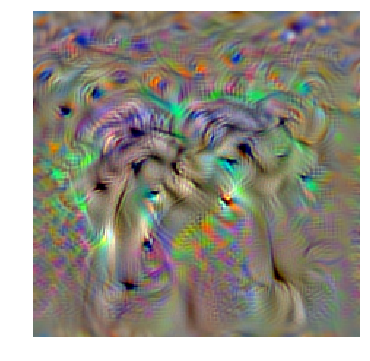

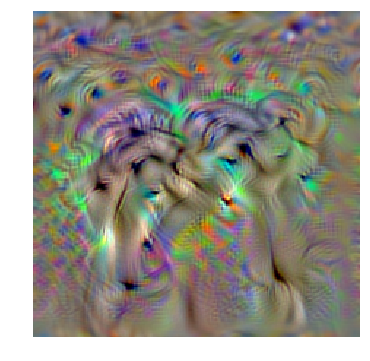

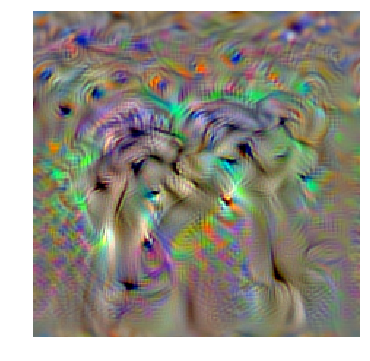

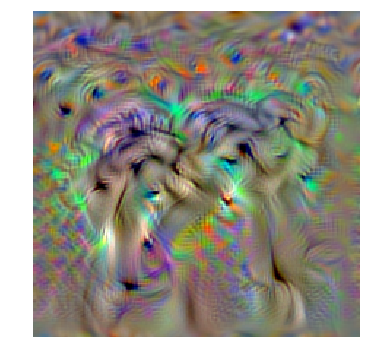

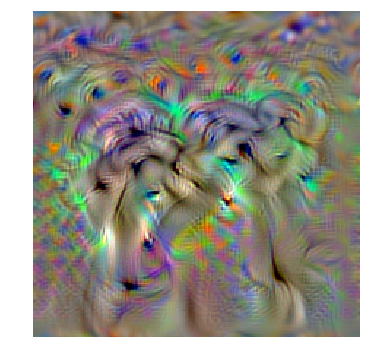

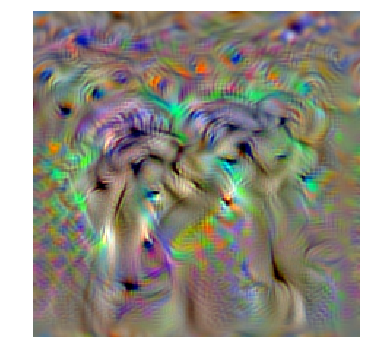

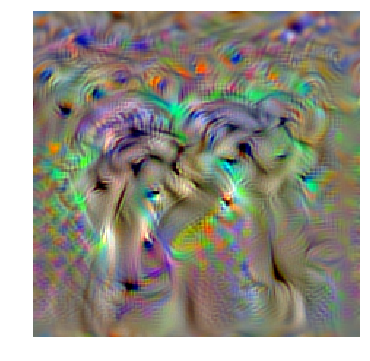

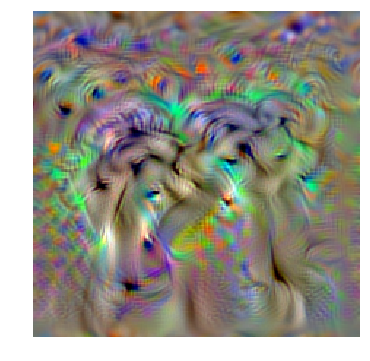

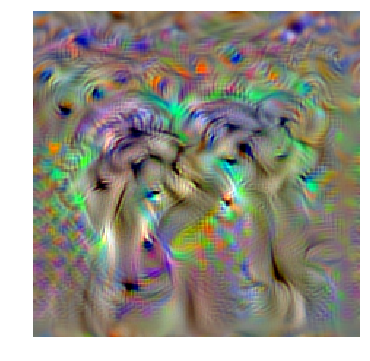

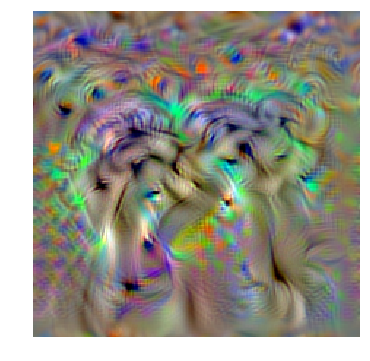

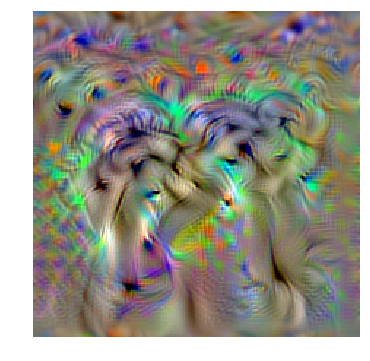

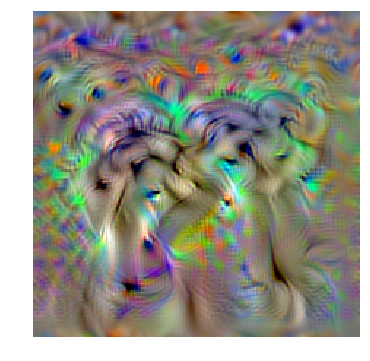

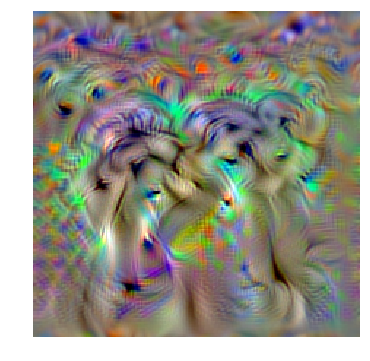

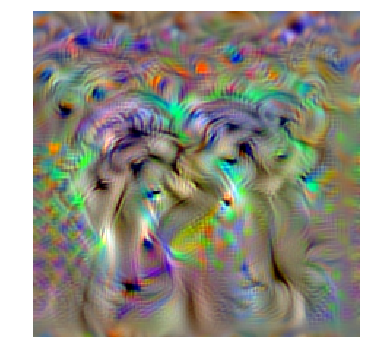

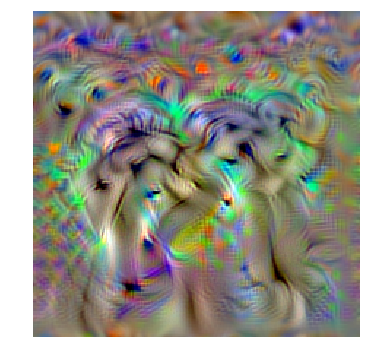

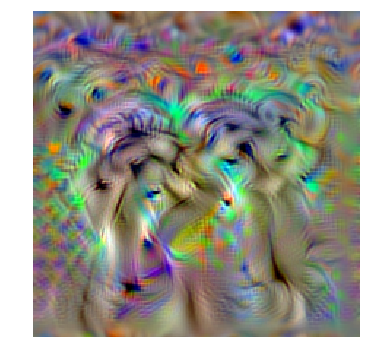

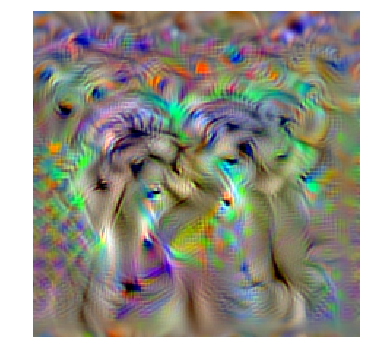

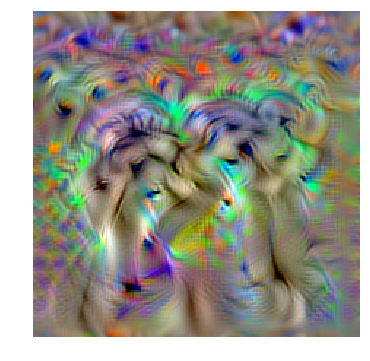

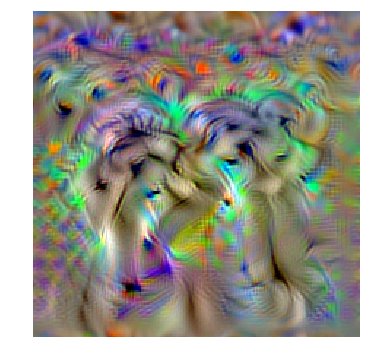

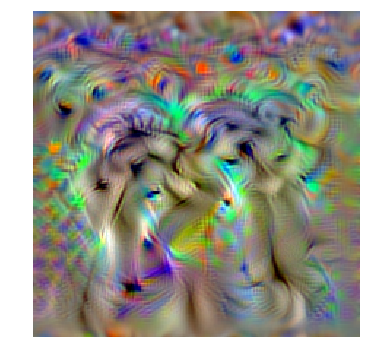

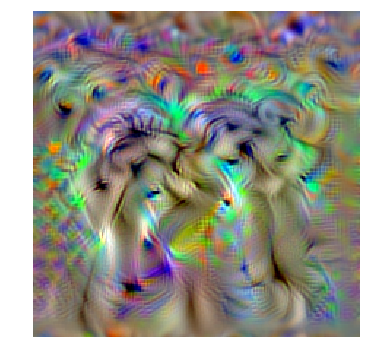

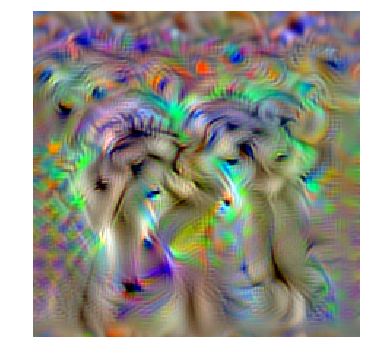

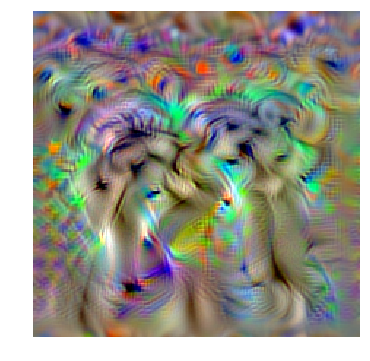

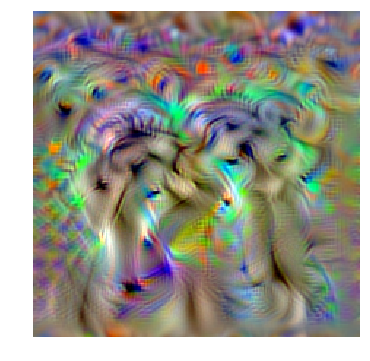

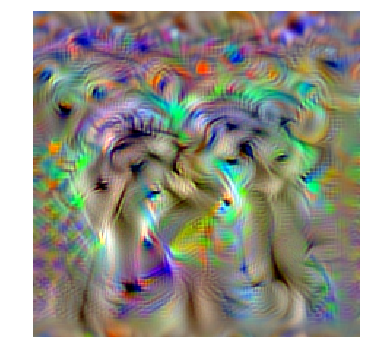

In [124]:
dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

target_y = 0
#target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model_original, dtype)